In [1]:
import pandas as pd
import numpy as np
from data_generator.batch_generator import BatchGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from models import AlexNet, LeNet
from keras.applications.vgg16 import VGG16

from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import backend as K
K.set_image_data_format('channels_last')

from keras.callbacks import ReduceLROnPlateau
from keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D, UpSampling2D
from keras.layers.core import Flatten, Dense, Dropout
from keras.models import Model

import glob

import tensorflow as tf

Using TensorFlow backend.


### ATENÇÃO: SELECIONAR OS PATHS PROS PESOS

In [3]:
activations = ['relu', 'lrelu']
img_treats=['image-treat-1', 'image-treat-2', 'image-treat-3', 'abordagem-4', 'abordagem-5', 'abordagem6', 'abordagem7', 'abordagem9']
nets = ['lenet', 'alexnet', 'vgg16']

activation, img_treat, net = activations[0], img_treats[5], nets[2]
activation, img_treat, net

('relu', 'abordagem6', 'vgg16')

In [4]:
test_dataset = BatchGenerator(box_output_format=['class_id'])
test_dataset.parse_csv(labels_filename='dataset/csv/imdb_csv/imdb_age_regression_test_split_47950-70-10-20.csv', 
                        images_dir='dataset/imdb-hand-crop/',
                        input_format=['image_name', 'class_id'])

In [5]:
print("Number of images in the dataset:", test_dataset.get_n_samples())

Number of images in the dataset: 9590


In [6]:
img_height, img_width, img_depth = (224,224,3)

#epochs = 90

batch_size=100
shuffle = True
ssd_train = False

#validation_batch_size = 10
#batch_size = validation_batch_size

# In[15]:

test_generator = test_dataset.generate(batch_size=batch_size,
                                       shuffle=shuffle,
                                       ssd_train=ssd_train,
                                       #flip=0.5,
                                       equalize=True,
                                       divide_by_stddev=255,
                                       returns={'processed_labels'},
                                       resize=(img_height, img_width))

In [7]:
steps = test_dataset.get_n_samples()

In [8]:
net

'vgg16'

In [9]:
'callbacks/' + net + '/age/class-weights-' + img_treat + '-' + activation + '*'

'callbacks/vgg16/age/class-weights-abordagem6-relu*'

In [14]:
approach = 'abordagem6' 
activation = 'relu'
net = 'vgg16'

if net == 'alexnet':
    model = AlexNet
elif net =='lenet':
    model = LeNet
elif net == 'vgg16':
    model = VGG16 
csvlogger_name = 'callbacks/'+net +'/age/consolidados/history-regression-' + approach + '-' + activation + '.csv'
checkpoint_filename = 'callbacks/'+net+'/age/consolidados/class-weights-' + approach + '-' + activation + '.{epoch:02d}-{val_loss:.2f}.hdf5'
csvlogger_name, checkpoint_filename

weights_path = glob.glob('callbacks/' + net + '/age/consolidados/class-weights-' + img_treat + '-' + activation + '*')[0]
#weights_path = glob.glob('callbacks/' + net + '/age/class-weights-' + img_treat + '-' + activation + '.' + melhor_epoca + '*')[0]

base_model = VGG16(include_top=True, weights=None, input_tensor=None, 
                  input_shape=(img_height, img_width, img_depth), 
                  pooling='avg')

base_model.summary()

#alexnet.model.load_weights('callbacks/alexnet/age/weights.24-1658.03.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
base_model.layers.pop()

last = base_model.layers[-1].output

preds = Dense(1)(last)
preds = Activation('relu')(preds)

model = Model(base_model.input, preds)

In [16]:
model.load_weights(weights_path)

In [17]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=True)

In [18]:
model.compile(loss='mae', optimizer=optimizer, metrics=['mean_squared_error'])

In [19]:
prev = next(test_generator)


#prev[1]

In [20]:
predict = model.predict(prev[0])

print(predict[:10])

[[37.047264]
 [37.047256]
 [37.047264]
 [37.047256]
 [37.047264]
 [37.04727 ]
 [37.047264]
 [37.047256]
 [37.047264]
 [37.047264]]


[39] [37.047256]


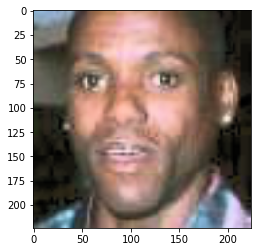

In [30]:
i=7
print(prev[1][i], predict[i])
import matplotlib.pyplot as plt
plt.imshow(prev[0][i])

In [22]:
x =  [i for i in range(batch_size)]

In [23]:
len(x)

100

In [24]:
import pandas as pd
df_results = pd.DataFrame({
    'Ŷ Previsto': prev[1].reshape(batch_size),
    'Y Real': list(predict.reshape(batch_size))#,
    #'Item': [i for i in range(1,batch_size+1)]
}, index=[i for i in range(batch_size)])

In [25]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("", ["0.5","0.1"])
cmap_rev = LinearSegmentedColormap.from_list("", ["0.1","0.5"])

In [26]:
df_results['Ŷ Previsto'] = df_results['Ŷ Previsto'] - df_results['Y Real']

df_results['Y Real']=0

In [27]:
df_results.rename({'Ŷ Previsto': 'Ŷ Previsto - Y Real', 'Y Real': 'Zero'}, inplace=True, axis=1)

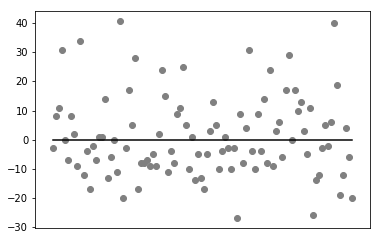

In [28]:
fig = df_results.plot(y='Zero', color='black')
fig.axes.scatter(x=df_results.index, y=df_results['Ŷ Previsto - Y Real'],color='grey')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_legend().set_visible(False)

In [33]:
fig.get_figure().savefig('graficos/result-reta/fig-reta-0-' + img_treat + '-'+ net +'-'+ activation +'.png')